# Example notebook for groupwise registration using GreedyFHist

### Step 1: Loading image data

GreedyFHist has some utility functions for load image data, but ultimately the only requirement is that image data can be converted to a `numpy.ndarray`.

In [1]:
import os
from os.path import join, exists
from pathlib import Path
import matplotlib.pyplot as plt

from greedyfhist.data_types import Image
from greedyfhist.registration import GreedyFHist
from greedyfhist.options import RegistrationOptions

In [2]:
OUTPUT_DIR = 'out'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

In [3]:
image_path1 = '../groupwise_examples/hes.tif'
image_path2 = '../groupwise_examples/mts.tif'
image_path3 = '../groupwise_examples/ihc.tif'

In [4]:
image1 = Image.load_from_path(image_path1)
image2 = Image.load_from_path(image_path2)
image3 = Image.load_from_path(image_path3)

Text(0.5, 1.0, 'IHC')

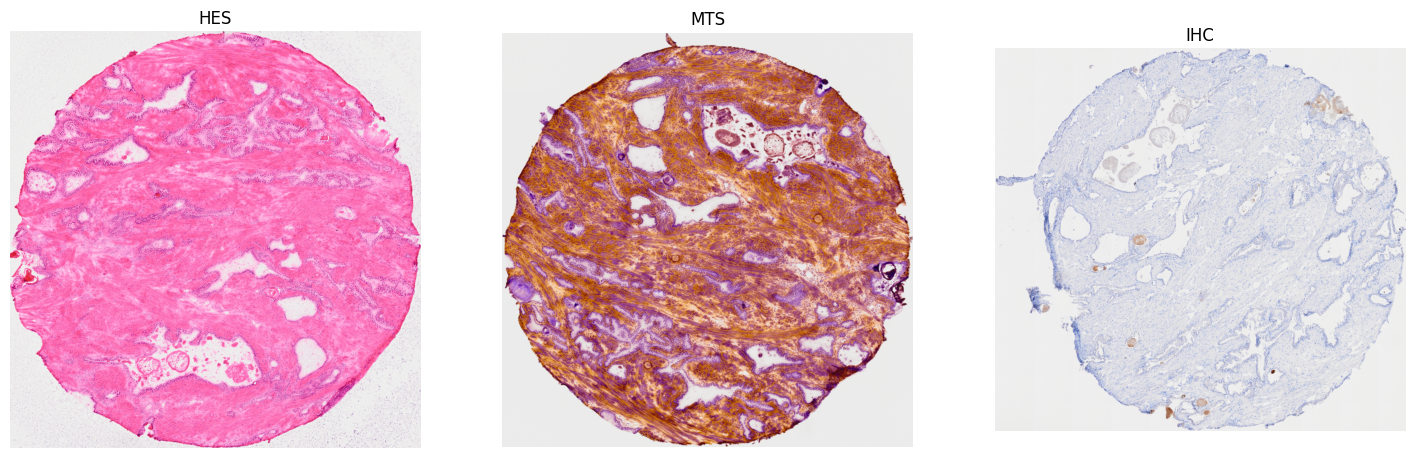

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(image1.data)
axs[0].set_title('HES')
axs[1].imshow(image2.data)
axs[1].set_title('MTS')
axs[2].imshow(image3.data)
axs[2].set_title('IHC')

### Step 2: Groupwise Registration

For the groupwise registration an ordered list of images needs be used. The result is a groupwise_registration_result which contains affine and nonrigid transformations from all moving image spaces to fixed image spaces.

In [6]:
# Set this option only to True, if greedy is used as an external docker image.
# If MIIT, GreedyFHist and Greedy are used from with the same docker container or if
# from no docker container at all, set this to False.

# Normally, this option can stay as False.
use_greedyfhist_from_external_docker_container = False

if use_greedyfhist_from_external_docker_container:
    path_to_greedy = 'mwess89/greedy:1.3.0-alpha'
    use_docker_container = True
else:
    # We assume that greedy is on PATH, else specify the whole file path.
    path_to_greedy = 'greedy'
    use_docker_container = False
    
path_to_greedy = '../../../test/greedy/build2/greedy'
registerer = GreedyFHist(path_to_greedy=path_to_greedy, use_docker_container=use_docker_container)

Using the property `grp_n_proc` we can enable concurrent registration. If not enough cores are available, ignore this options. (Default is None which deactivates concurrency.)

In [7]:
options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8
options.grp_n_proc = 3

In [8]:
# For groupwise registration we need to extract an ordered list of images.
# This list can either be a list of images or a list of tuple of shape (image, mask).

img_list = [image1.data, image2.data, image3.data]

In [9]:
groupwise_registration_result, _ = registerer.groupwise_registration(img_list, options=options)

After groupwise registration, we receive an object of type GroupwiseRegistrationResult that contains a pairwise list of affine registrations and nonrigid registrations between affinely transformed moving images and the fixed image.

In [10]:
# For getting the registration of any moving to the fixed image we can use the get_transforms method.
# image1_to_image3_transform and image2_to_image3_transform can be used the same way as transformations from the pairwise transform.

image1_to_image3_transform = groupwise_registration_result.get_transforms(0)
image2_to_image3_transform = groupwise_registration_result.get_transforms(1)

### Step 3: Transform to fixed image spaces.

In [11]:
warped_image1 = registerer.transform_image(image1.data, image1_to_image3_transform.registration.forward_transform, 'LINEAR')
warped_image2 = registerer.transform_image(image2.data, image2_to_image3_transform.registration.forward_transform, 'LINEAR')

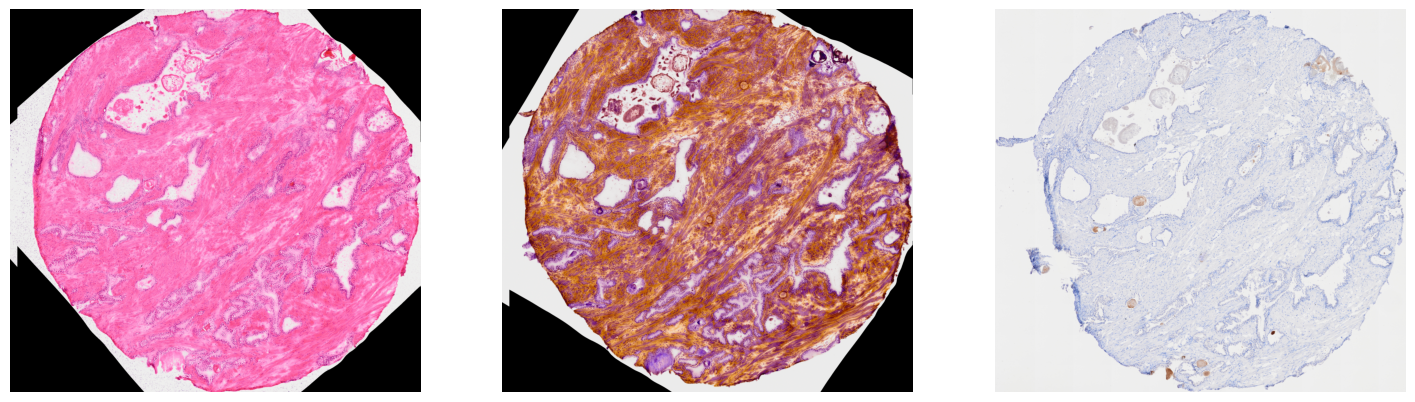

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(warped_image1)
axs[1].imshow(warped_image2)
axs[2].imshow(image3.data)

### Alternative: Registration using fileppaths

GreedyFHists registration can also be invoked using only filepaths.

In [13]:
image_path1 = '../groupwise_examples/hes.tif'
image_path2 = '../groupwise_examples/mts.tif'
image_path3 = '../groupwise_examples/ihc.tif'

target_directory = join(OUTPUT_DIR, 'groupwise_reg_dir')

In [14]:
registerer = GreedyFHist(path_to_greedy=path_to_greedy, use_docker_container=use_docker_container)

In [15]:
image_path_list = [image_path1, image_path2, image_path3]
groupwise_reg_result, warped_images = registerer.groupwise_registration_from_filepaths(image_path_list,
                                                 target_directory)

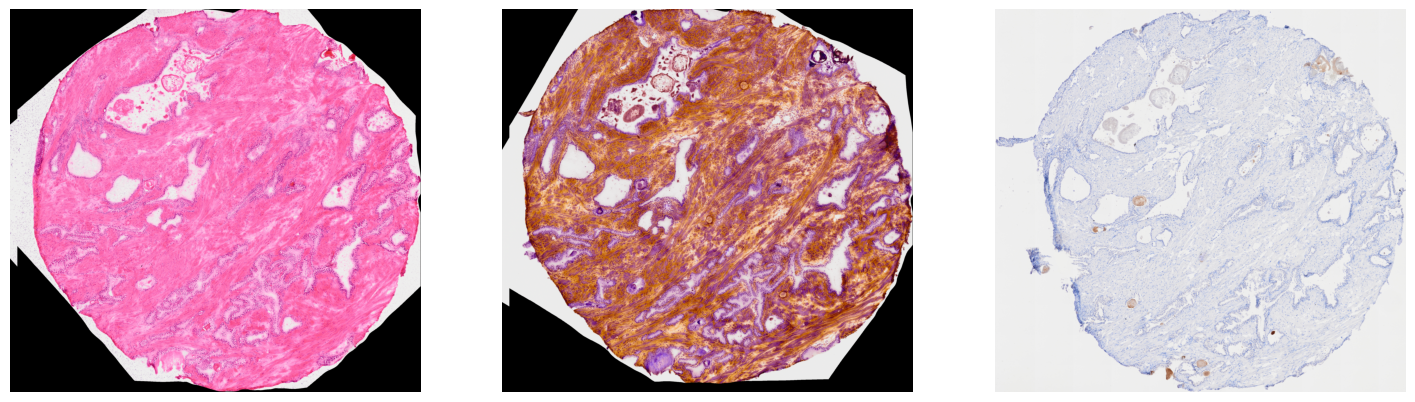

In [16]:
# Note that images in this example differ slightly between this and the previous example in the white background area.
# This is due to how the transformations were applied differently. 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for i, img in enumerate(warped_images):
    axs[i].imshow(img)
    axs[i].axis('off')

In [17]:
os.listdir(target_directory), os.listdir(join(target_directory, 'images'))

(['images', 'transform'], ['ihc.ome.tif', 'mts.ome.tif', 'hes.ome.tif'])